> Class

# import

In [1]:
import rpy2
import rpy2.robjects as ro 
from rpy2.robjects.vectors import FloatVector 
from rpy2.robjects.packages import importr

import torch
import numpy as np
from tqdm import tqdm

import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import GConvGRU

import matplotlib.pyplot as plt
import pandas as pd

import time

from scipy.interpolate import interp1d

In [2]:
class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features, filters):
        super(RecurrentGCN, self).__init__()
        self.recurrent = GConvGRU(node_features, filters, 2)
        self.linear = torch.nn.Linear(filters, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        return h

# 시간 측정 방법

```python
t1= time.time()
for epoc in range(1000):
    ## 1 
    yhat = net(x) 
    ## 2 
    loss = loss_fn(yhat,y)
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()
t2 = time.time()
t2-t1
```

# R

In [3]:
%load_ext rpy2.ipython

In [5]:
%%R
library(GNAR)
library(igraph)

# Data

In [6]:
%%R
edges <- as.matrix(fiveNet)
data("fiveNode")

In [7]:
%R -o fiveVTS
%R -o edges

- node: 5
- time 200

# functions 

In [8]:
def vis(spatiotemporaldata):
    N = spatiotemporaldata.shape[1]
    fig, ax = plt.subplots(N,1)
    for n in range(N):
        ax[n].plot(spatiotemporaldata[:,n])
        ax[n].set_title('node='+str(n))
    #fig.set_width()
    fig.set_figheight(N*2) 
    fig.tight_layout()
    return fig 

In [9]:
def vis2(spatiotemporaldata1,spatiotemporaldata2):
    N = spatiotemporaldata1.shape[1]
    fig, ax = plt.subplots(N,1)
    for n in range(N):
        ax[n].plot(spatiotemporaldata1[:,n],label='data1')
        ax[n].plot(spatiotemporaldata2[:,n],label='data2')
        ax[n].set_title('node='+str(n))
        ax[n].legend()
    #fig.set_width()
    fig.set_figheight(N*2) 
    fig.tight_layout()
    return fig 

In [10]:
edges_tensor = torch.tensor(edges)

In [11]:
nonzero_indices = edges_tensor.nonzero()

In [12]:
fiveNet_edge = np.array(nonzero_indices).T

In [13]:
T = 200
N = 5 # number of Nodes
E = fiveNet_edge
V = np.array([1,2,3,4,5])
t = np.arange(0,T)
node_features = 1

In [14]:
edge_index = torch.tensor(E)
edge_attr = torch.tensor(np.array([1,1,1,1,1,1,1,1,1,1]),dtype=torch.float32)

In [15]:
fiveVTS_train = fiveVTS[:int(len(fiveVTS)*0.8)]
fiveVTS_test = fiveVTS[int(len(fiveVTS)*0.8):]

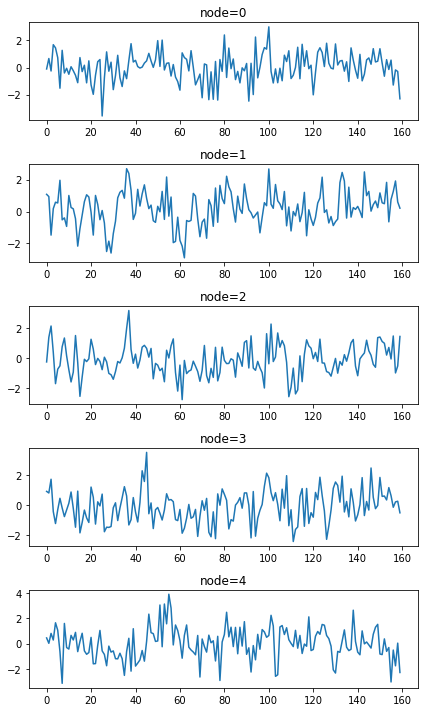

In [16]:
vis(fiveVTS_train);

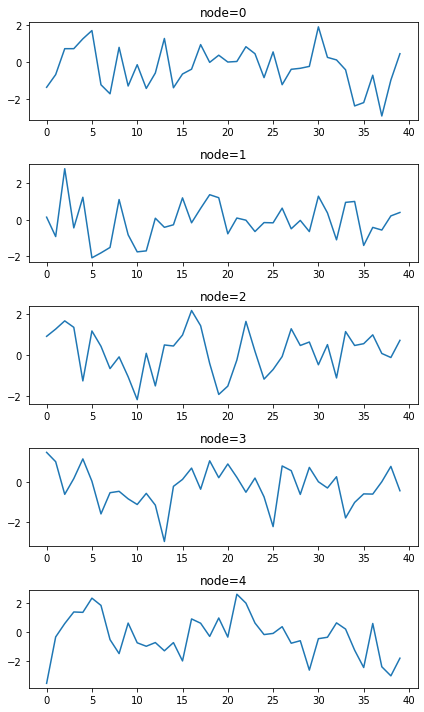

In [17]:
vis(fiveVTS_test);

# Random Missing Values

In [18]:
class Missing:
    def __init__(self,df):
        self.df = df
        self.N = N
        self.number = []
    def miss(self,percent=0.5):
        self.missing = self.df.copy()
        self.percent = percent
        for i in range(self.N):
            self.seed = np.random.choice(1000,1,replace=False)
            np.random.seed(self.seed)
            self.number.append(np.random.choice(int(len(self.df))-1,int(len(self.df)*self.percent),replace=False))
            self.missing[self.number[i],i] = float('nan')
    def first_mean(self):
        self.train_mean = self.missing.copy()
        for i in range(self.N):
            self.train_mean[self.number[i],i] = np.nanmean(self.missing[:,i])
    def second_linear(self):
        self.train_linear = pd.DataFrame(self.missing)
        self.train_linear.interpolate(method='linear', inplace=True)
        self.train_linear = self.train_linear.fillna(0)
        self.train_linear = np.array(self.train_linear).reshape(int(len(self.df)),N)

In [19]:
_zero = Missing(fiveVTS_train)

In [20]:
_zero.miss(percent = 0.1)

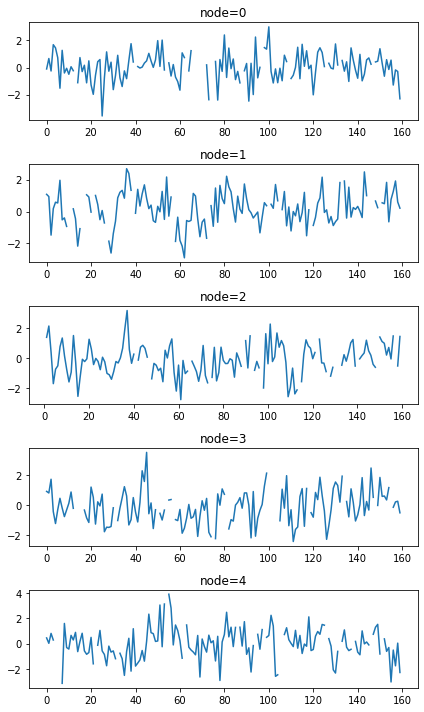

In [21]:
vis(_zero.missing);

In [22]:
_zero.first_mean()

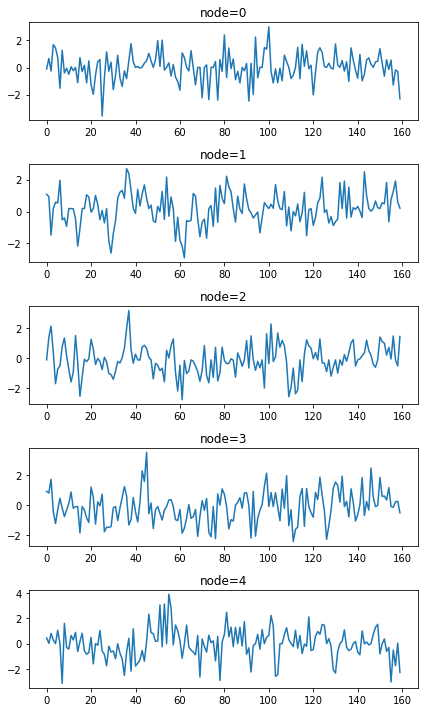

In [23]:
vis(_zero.train_mean);

In [24]:
_zero.second_linear()

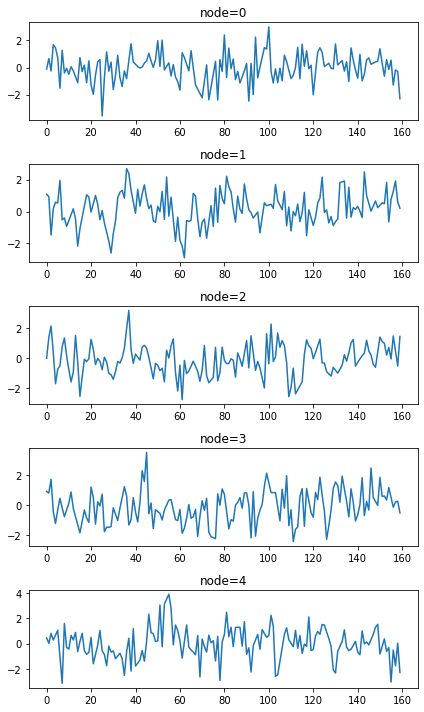

In [25]:
vis(np.array(_zero.train_linear).reshape(160,5));

In [27]:
train_X_mean = torch.tensor(_zero.train_mean).reshape(int(T*0.8),N,1).float()[:int(T*0.8-1),:,:]
train_y_mean = torch.tensor(_zero.train_mean).reshape(int(T*0.8),N,1).float()[1:,:,:]

In [28]:
train_X_linear = torch.tensor(_zero.train_linear).reshape(int(T*0.8),N,1).float()[:int(T*0.8-1),:,:]
train_y_linear = torch.tensor(_zero.train_linear).reshape(int(T*0.8),N,1).float()[1:,:,:]

In [29]:
xt_test = torch.tensor(fiveVTS_test.reshape(int(T*0.2),N,1)[:-1,:,:]).float()

In [128]:
class Method:
    def __init__(self,df,time,seednumber,trainx,trainy):
        self.test_data = fiveVTS_test
        self.seednumber = seednumber
        self.N = N
        self.timepoint = time -1
        self.edge_index = edge_index
        self.edge_attr = edge_attr
        self.node_features = node_features
        self.X = trainx
        self.df = _zero.train_mean
        self.y = trainy
        self.xt_test = xt_test
        self.w = np.zeros(((self.timepoint)*self.N,(self.timepoint)*self.N))
        self.mse = []
        self.mae = []
        self.train_result_list = []
        self.test_result_list = []
    def _weight(self):
        for i in range((self.timepoint)*self.N):
            for j in range((self.timepoint)*self.N):
                if i==j :
                    self.w[i,j] = 0
                elif np.abs(i-j) <= 1 : 
                    self.w[i,j] = 1
    def _STGCN(self):
        model = RecurrentGCN(node_features=1, filters=4)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
        model.train()
        for epoch in tqdm(range(100)):
            for time, (xt,yt) in enumerate(zip(self.X,self.y)):
                y_hat = model(xt, edge_index, edge_attr)
                cost = torch.mean((y_hat-yt)**2)
                cost.backward()
                optimizer.step()
                optimizer.zero_grad()
        self.train_result = torch.stack([model(xt, edge_index, edge_attr) for xt in self.X]).detach().numpy()
        self.test_result = torch.stack([model(xt, edge_index, edge_attr) for xt in self.xt_test]).detach().numpy()
        self.train_result_list.append(self.train_result)
        self.test_result_list.append(self.test_result)
        for i in range(self.N):
            self.mse.append(np.mean((self.test_data[1:,i] - self.test_result.reshape(int(len(self.xt_test)),self.N)[:,i])**2))
        for i in range(self.N):
            self.mae.append(np.mean(np.abs(self.test_data[1:,i] - self.test_result.reshape(int(len(self.xt_test)),self.N)[:,i])))
    def FT(self):
        self._weight()
        self._STGCN()
        self.d = np.array(self.w.sum(axis=1))
        self.D = np.diag(self.d)
        self.L = np.array(np.diag(1/np.sqrt(self.d)) @ (self.D-self.w) @ np.diag(1/np.sqrt(self.d)))
        self.lamb, self.Psi = np.linalg.eigh(self.L)
        self.Lamb = np.diag(self.lamb)
        self.fhatbar = self.Psi.T @ self.train_result.reshape((self.timepoint)*self.N,1)
        ebayesthresh = importr('EbayesThresh').ebayesthresh
        self.fhatbar_threshed = ebayesthresh(FloatVector(self.fhatbar))
        self.fhatbarhat = self.Psi @ self.fhatbar_threshed
        self.FT_result = self.fhatbarhat.reshape(self.timepoint,self.N,1)
        for i in range(N): 
            self.df[self.seednumber[i],i] = torch.tensor(self.FT_result)[self.seednumber[i],i,0]

# missing: 50%

## Mean

mean result

In [ ]:
vis(_zero.train_mean);

In [82]:
_two = Method(_zero.train_mean,160,_zero.number,train_X_mean,train_y_mean)

In [83]:
_two.FT()

100%|██████████| 100/100 [00:53<00:00,  1.86it/s]


ST-GCN

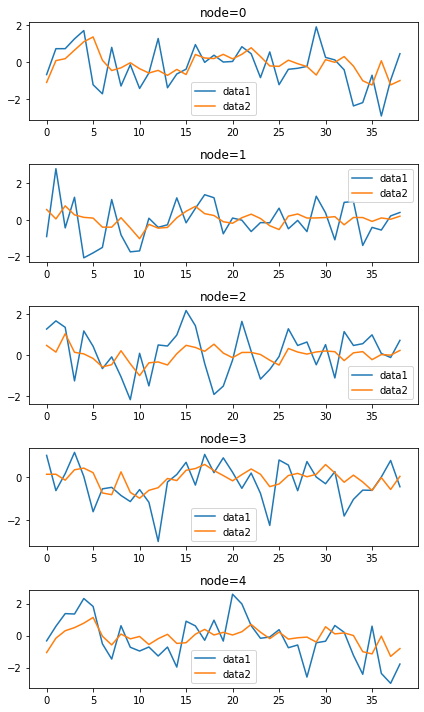

In [85]:
vis2(fiveVTS_test[1:],_two.test_result);

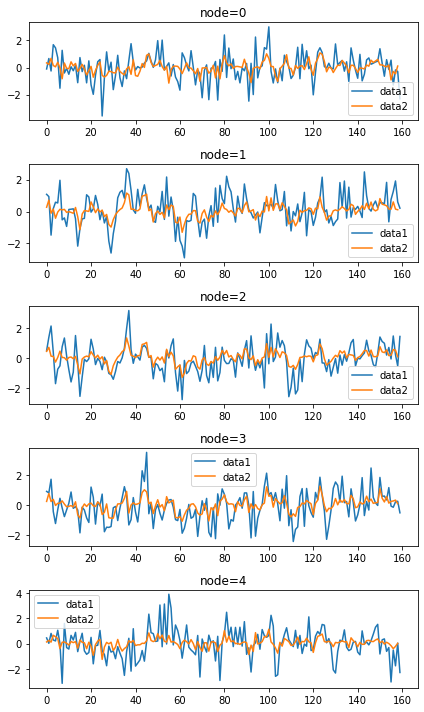

In [86]:
vis2(_zero.train_mean,_two.train_result);

Ebayes result

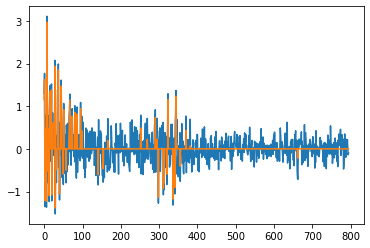

In [87]:
plt.plot(_two.fhatbar)
plt.plot(_two.fhatbar_threshed)

Inverse FT result

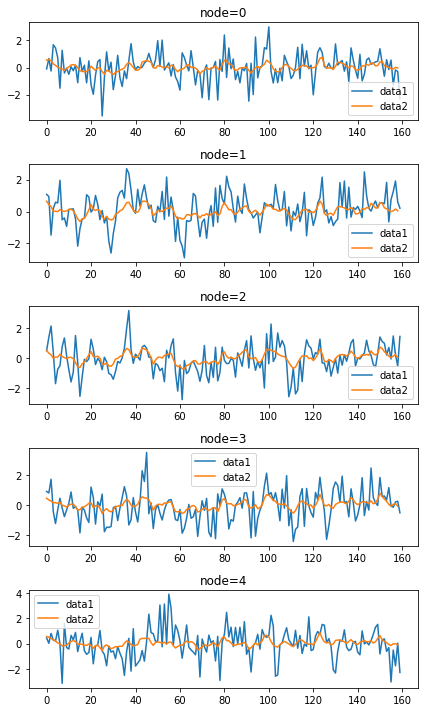

In [88]:
vis2(_zero.train_mean,_two.FT_result.reshape(159,5));

In [91]:
_three = Method(_zero.train_mean,160,_zero.number,train_X_mean,train_y_mean)

In [92]:
_three.FT()

100%|██████████| 100/100 [00:54<00:00,  1.85it/s]


ST-GCN

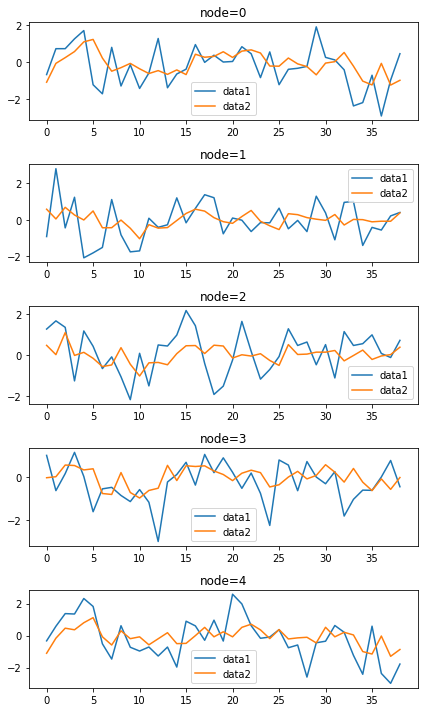

In [93]:
vis2(fiveVTS_test[1:],_three.test_result);

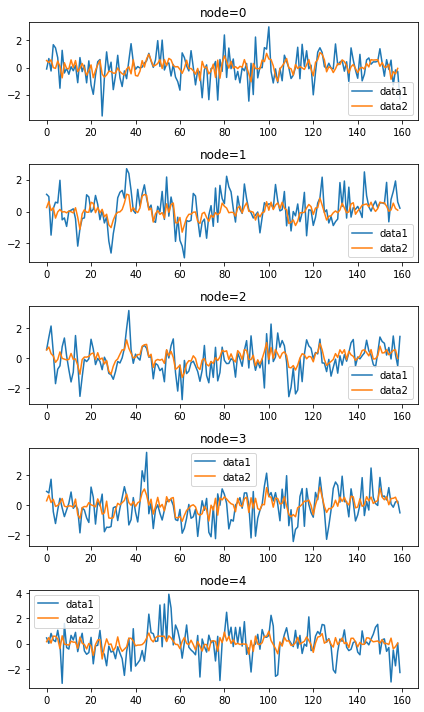

In [94]:
vis2(_zero.train_mean,_three.train_result);

Ebayes result

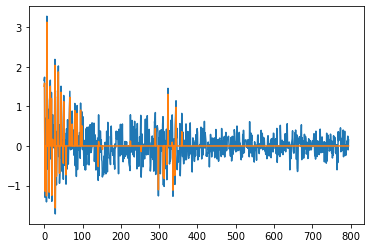

In [95]:
plt.plot(_three.fhatbar)
plt.plot(_three.fhatbar_threshed)

Inverse FT result

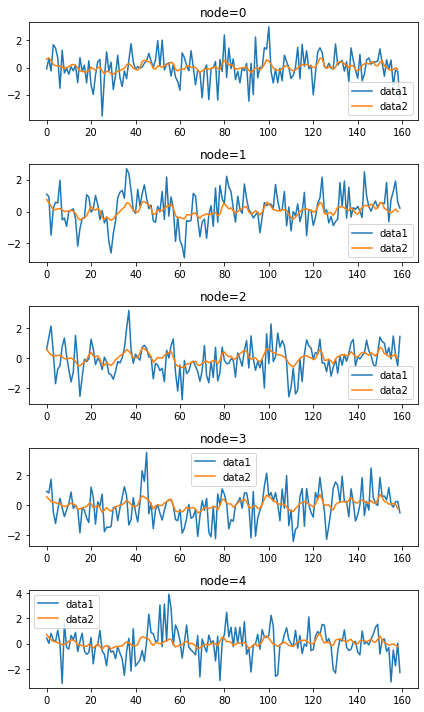

In [96]:
vis2(_zero.train_mean,_three.FT_result.reshape(159,5));

In [97]:
pd.DataFrame({'1':_two.mse,'2':_three.mse})

,1,2
0,1.234416,1.241689
1,1.113818,1.158297
2,1.051161,1.085383
3,0.760066,0.818954
4,1.262365,1.275052


In [98]:
pd.DataFrame({'1':_two.mae,'2':_three.mae})

,1,2
0,0.814436,0.829218
1,0.860375,0.868764
2,0.857613,0.869810
3,0.680214,0.707047
4,0.919505,0.923127


## Linear

In [ ]:
vis(np.array(_zero.train_linear).reshape(160,5));

In [101]:
__two = Method(_zero.train_linear,160,_zero.number,train_X_linear,train_y_linear)

In [102]:
__two.FT()

100%|██████████| 100/100 [00:54<00:00,  1.85it/s]


ST-GCN

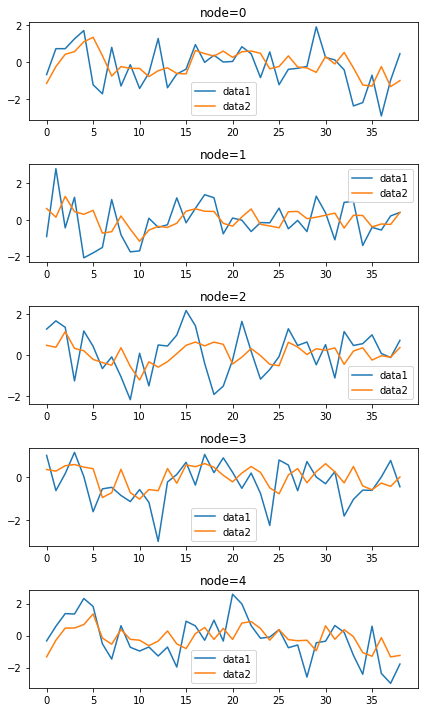

In [103]:
vis2(fiveVTS_test[1:],__two.test_result);

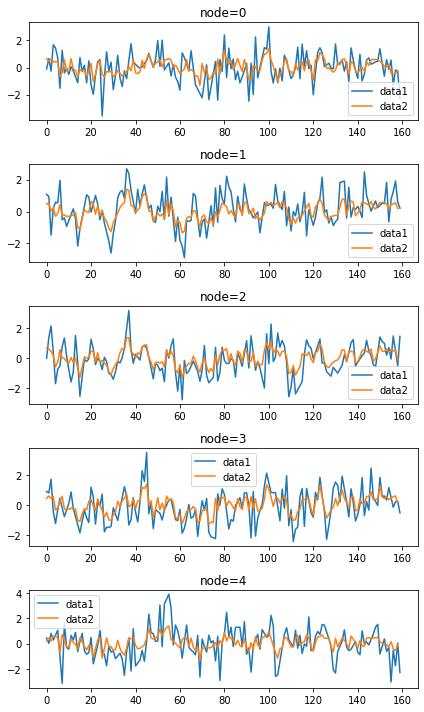

In [104]:
vis2(_zero.train_linear,__two.train_result);

Ebayes result

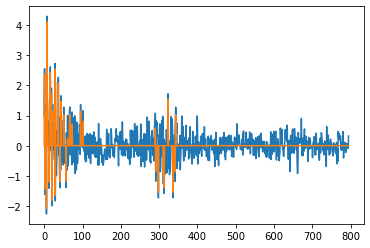

In [105]:
plt.plot(__two.fhatbar)
plt.plot(__two.fhatbar_threshed)

Inverse FT result

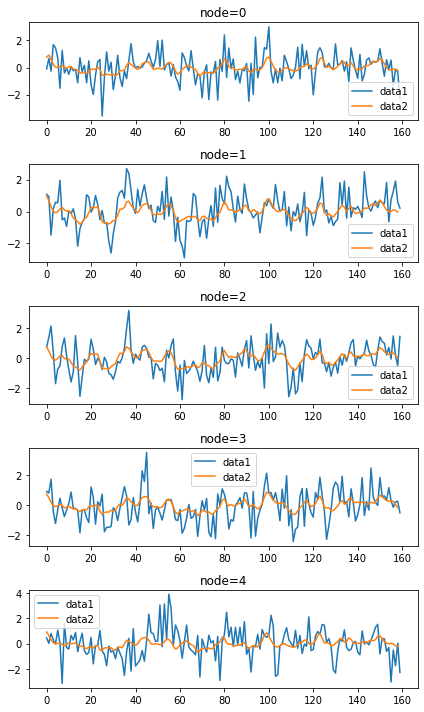

In [106]:
vis2(_zero.train_mean,__two.FT_result.reshape(159,5));

In [107]:
__three = Method(_zero.train_linear,160,_zero.number,train_X_linear,train_y_linear)

In [108]:
__three.FT()

100%|██████████| 100/100 [00:53<00:00,  1.86it/s]


ST-GCN

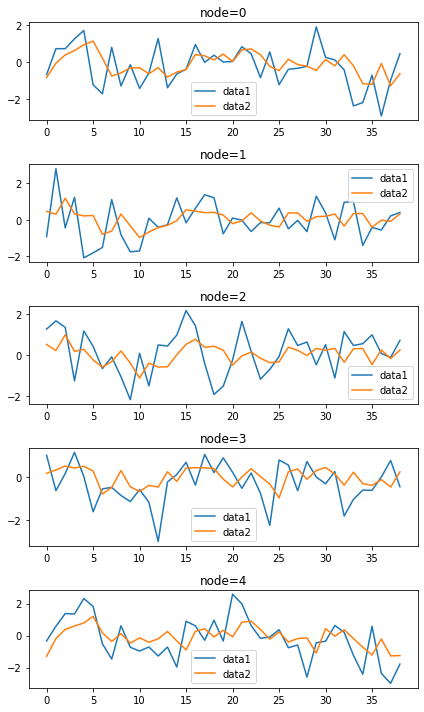

In [109]:
vis2(fiveVTS_test[1:],__three.test_result);

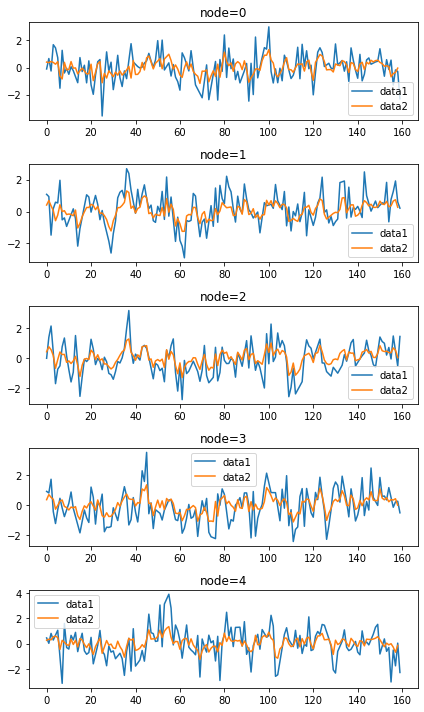

In [110]:
vis2(_zero.train_linear,__three.train_result);

Ebayes result

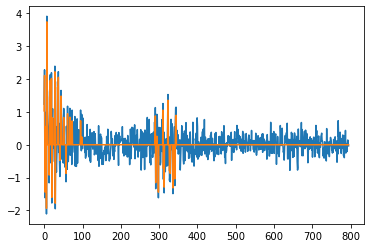

In [111]:
plt.plot(__three.fhatbar)
plt.plot(__three.fhatbar_threshed)

Inverse FT result

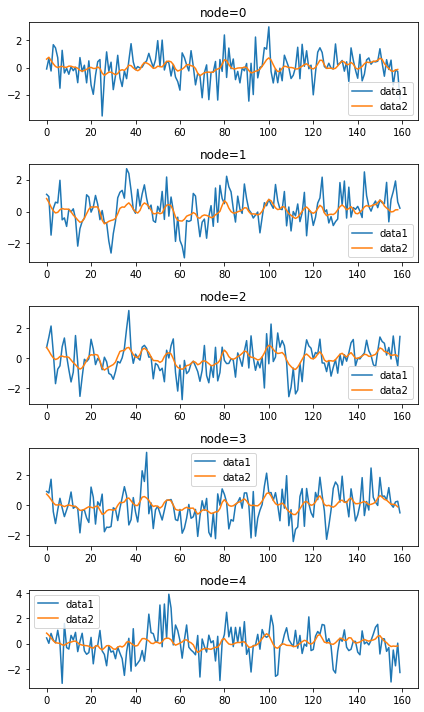

In [113]:
vis2(_zero.train_mean,__three.FT_result.reshape(159,5));

In [114]:
pd.DataFrame({'1':__two.mse,'2':__three.mse})

,1,2
0,1.261941,1.129225
1,1.253917,1.182656
2,1.140057,1.080212
3,0.849157,0.871581
4,1.284821,1.295292


In [115]:
pd.DataFrame({'1':__two.mae,'2':__three.mae})

,1,2
0,0.844504,0.771447
1,0.887847,0.873044
2,0.872196,0.858041
3,0.738446,0.741095
4,0.933482,0.946077


# missing : 40%

In [116]:
__zero = Missing(fiveVTS_train)

In [117]:
__zero.miss(percent = 0.4)

In [118]:
__zero.first_mean()

In [119]:
__zero.second_linear()

## mean

In [130]:
t1= time.time()
ttt = 160
_mse = []
_mae = []
_train_result = []
_test_result = []
b = __zero.train_mean
c = __zero.number
d = train_X_mean
f = train_y_mean
for i in range(1):
    a = Method(b,ttt,c,d,f)
    a.FT()
    _mse.append(a.mse)
    _mae.append(a.mae)
    _train_result.append(a.train_result)
    _test_result.append(a.test_result)
    b = a.FT_result
t2 = time.time()
t2-t1

100%|██████████| 100/100 [00:53<00:00,  1.86it/s]


54.81813645362854

In [123]:
mean_mse100_40 = pd.DataFrame(_mse)

In [ ]:
plt.plot(mean_mse100_40.T)

In [ ]:
plt.plot(mean_mse100_40[0])

In [126]:
mean_mae100_40 = pd.DataFrame(_mae)

In [ ]:
plt.plot(mean_mae100_40.T)

In [ ]:
vis2(fiveVTS_test[1:],_two1.test_result);

In [ ]:
vis2(fiveVTS_test[1:],_three1.test_result);

In [ ]:
vis2(fiveVTS_test[1:],_four1.test_result);

In [ ]:
vis2(fiveVTS_test[1:],_five1.test_result);

## linear

In [ ]:
t1= time.time()
ttt = 160
_mse = []
_mae = []
b = __zero.train_linear
for i in range(100):
    a = Method(b,ttt)
    a.FT()
    _mse.append(a.mse)
    _mae.append(a.mae)
    ttt -= 1
    b = a.FT_result
t2 = time.time()
t2-t1

In [ ]:
linear_mse100_40 = pd.DataFrame(_mse)

In [ ]:
plt.plot(linear_mse100_40.T)

In [ ]:
plt.plot(linear_mse100_40[0])

In [ ]:
linear_mae100_40 = pd.DataFrame(_mae)

In [ ]:
plt.plot(linear_mae100_40.T)

In [ ]:
__two1 = Method(__zero.train_linear,160)

In [ ]:
__two1.FT()

In [ ]:
__three1 = Method(__two1.FT_result,159)

In [ ]:
__three1.FT()

In [ ]:
__four1 = Method(__three1.FT_result,158)

In [ ]:
__four1.FT()

In [ ]:
__five1 = Method(__four1.FT_result,157)

In [ ]:
__five1.FT()

In [ ]:
pd.DataFrame({'1':__two1.mse,'2':__three1.mse,'3':__four1.mse,'4':__five1.mse})

In [ ]:
plt.plot(pd.DataFrame({'1':__two1.mse,'2':__three1.mse,'3':__four1.mse,'4':__five1.mse}))

In [ ]:
pd.DataFrame({'1':__two1.mae,'2':__three1.mae,'3':__four1.mae,'4':__five1.mae})

In [ ]:
vis2(fiveVTS_test[1:],__two1.test_result);

In [ ]:
vis2(fiveVTS_test[1:],__three1.test_result);

In [ ]:
vis2(fiveVTS_test[1:],__four1.test_result);

In [ ]:
vis2(fiveVTS_test[1:],__five1.test_result);

# missing : 70%

In [ ]:
____zero = Missing(fiveVTS_train)

In [ ]:
____zero.miss(percent = 0.7)

In [ ]:
____zero.first_mean()

In [ ]:
____zero.second_linear()

## Mean

In [ ]:
_two3 = Method(____zero.train_mean,160)

In [ ]:
_two3.FT()

In [ ]:
_three3 = Method(_two3.FT_result,159)

In [ ]:
_three3.FT()

In [ ]:
_four3 = Method(_three3.FT_result,158)

In [ ]:
_four3.FT()

In [ ]:
_five3 = Method(_four3.FT_result,157)

In [ ]:
_five3.FT()

In [ ]:
pd.DataFrame({'1':_two3.mse,'2':_three3.mse,'3':_four3.mse,'4':_five3.mse})

In [ ]:
plt.plot(pd.DataFrame({'1':_two3.mse,'2':_three3.mse,'3':_four3.mse,'4':_five3.mse}))

In [ ]:
pd.DataFrame({'1':_two3.mae,'2':_three3.mae,'3':_four3.mae,'4':_five3.mae})

In [ ]:
vis2(fiveVTS_test[1:],_two3.test_result);

In [ ]:
vis2(fiveVTS_test[1:],_three3.test_result);

In [ ]:
vis2(fiveVTS_test[1:],_four3.test_result);

In [ ]:
vis2(fiveVTS_test[1:],_five3.test_result);

## Linear

In [ ]:
__two3 = Method(____zero.train_linear,160)

In [ ]:
__two3.FT()

In [ ]:
__three3 = Method(__two3.FT_result,159)

In [ ]:
__three3.FT()

In [ ]:
__four3 = Method(__three3.FT_result,158)

In [ ]:
__four3.FT()

In [ ]:
__five3 = Method(__four3.FT_result,157)

In [ ]:
__five3.FT()

In [ ]:
pd.DataFrame({'1':__two3.mse,'2':__three3.mse,'3':__four3.mse,'4':__five3.mse})

In [ ]:
plt.plot(pd.DataFrame({'1':__two3.mse,'2':__three3.mse,'3':__four3.mse,'4':__five3.mse}).iloc[:,:3])
plt.plot(pd.DataFrame({'1':__two3.mse,'2':__three3.mse,'3':__four3.mse,'4':__five3.mse}).iloc[:,3:],'r')

# missing : 10%

In [ ]:
___zero = Missing(fiveVTS_train)

In [ ]:
___zero.miss(percent = 0.1)

In [ ]:
___zero.first_mean()

In [ ]:
___zero.second_linear()

## Mean

In [ ]:
_two2 = Method(___zero.train_mean,160)

In [ ]:
_two2.FT()

In [ ]:
_three2 = Method(_two2.FT_result,159)

In [ ]:
_three2.FT()

In [ ]:
_four2 = Method(_three2.FT_result,158)

In [ ]:
_four2.FT()

In [ ]:
pd.DataFrame({'1':_two2.mse,'2':_three2.mse,'3':_four2.mse})

In [ ]:
plt.plot(pd.DataFrame({'1':_two2.mse,'2':_three2.mse,'3':_four2.mse}))

## Linear

In [ ]:
__two2 = Method(__zero.train_linear,160)

In [ ]:
__two2.FT()

In [ ]:
__three2 = Method(__two2.FT_result,159)

In [ ]:
__three2.FT()

In [ ]:
__four2 = Method(__three2.FT_result,158)

In [ ]:
__four2.FT()

In [ ]:
pd.DataFrame({'1':__two2.mse,'2':__three2.mse,'3':__four2.mse})

In [ ]:
plt.plot(pd.DataFrame({'1':__two2.mse,'2':__three2.mse,'3':__four2.mse}))

# missing 50%, 100번 반복 -> 30분 정도 걸림!

## mean

In [ ]:
t1= time.time()
ttt = 160
_mse = []
_mae = []
b = _zero.train_mean
for i in range(100):
    a = Method(b,ttt)
    a.FT()
    _mse.append(a.mse)
    _mae.append(a.mae)
    ttt -= 1
    b = a.FT_result
t2 = time.time()
t2-t1

In [ ]:
mean_mse100 = pd.DataFrame(_mse)

노드별

In [ ]:
plt.boxplot(mean_mse100);

In [ ]:
mean_mae100 = pd.DataFrame(_mae)

In [ ]:
plt.boxplot(mean_mae100);

## linear

In [ ]:
t1= time.time()
ttt = 160
_mse = []
_mae = []
b = _zero.train_linear
for i in range(100):
    a = Method(b,ttt)
    a.FT()
    _mse.append(a.mse)
    _mae.append(a.mae)
    ttt -= 1
    b = a.FT_result
t2 = time.time()
t2-t1

In [ ]:
linear_mse100 = pd.DataFrame(_mse)

In [ ]:
plt.boxplot(linear_mse100);

In [ ]:
linear_mae100 = pd.DataFrame(_mae)

In [ ]:
plt.plot(linear_mae100.T)

In [ ]:
plt.boxplot(mean_mse100);

In [ ]:
node_name = ['node 1','node 2','node 3','node 4','node 5']

In [ ]:
mean_mse100.columns = node_name

In [ ]:
linear_mse100.columns = node_name

In [ ]:
pd.concat([mean_mse100.assign(inter_method='mean'),linear_mse100.assign(inter_method='linear')])

In [ ]:
mean_mse100.to_csv('mean_mse100.csv')

In [ ]:
linear_mse100.to_csv('linear_mse100.csv')

# missing 70%, 100번 반복

## mean

In [ ]:
t1= time.time()
ttt = 160
_mse = []
_mae = []
b = ____zero.train_mean
for i in range(100):
    a = Method(b,ttt)
    a.FT()
    _mse.append(a.mse)
    _mae.append(a.mae)
    ttt -= 1
    b = a.FT_result
t2 = time.time()
t2-t1

In [ ]:
mean_mse100_70 = pd.DataFrame(_mse)

In [ ]:
mean_mae100_70 = pd.DataFrame(_mae)

## linear

In [ ]:
t1= time.time()
ttt = 160
_mse = []
_mae = []
b = ____zero.train_linear
for i in range(100):
    a = Method(b,ttt)
    a.FT()
    _mse.append(a.mse)
    _mae.append(a.mae)
    ttt -= 1
    b = a.FT_result
t2 = time.time()
t2-t1

In [ ]:
linear_mse100_70 = pd.DataFrame(_mse)

In [ ]:
linear_mae100_70 = pd.DataFrame(_mae)